In [1]:
from nltk.corpus.reader.wordnet import Lemma
import nltk

# For file reading
import os
from os import listdir
# For pre-processing 
from nltk import word_tokenize
from nltk.tokenize import punkt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re
import pandas as pd
import numpy as np
import string
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
def read_data(path: str) -> list:
    """ Read files from a directory and then append the data of each file into a list. """
    folder = listdir(path)
    res = []
    for files in folder:
        # check if current path is a file
        if files != "README.txt":
            filePath = os.path.join(path, files)
            if os.path.isfile(filePath):
                with open(filePath, "r") as file:
                    lines = file.readlines()
                res.append(lines)
    return res

def get_raw_data(res: list) -> list:
    '''Get avaliable data for training and testing data'''
    # Getting avaliable data for LSTM
    avaliable_data = []
    for document in res:
        # Remove \n from the string list
        processedList = [s.strip() for s in document]
        # Remove [t] tag
        processedList = [re.sub('\[t\]', '', word) for word in processedList]
        # Store values in list
        for sentence in processedList:
            # Remove non-tagged data and empty data
            if (not sentence.startswith("##")) and (sentence != ""):
                avaliable_data.append(sentence)
                
    # Store raw review and raw sentiment seperatly in 2 lists
    raw_tag = []
    raw_text = []
    
    for data in avaliable_data:
        # Split data into tag and text
        split_data = data.split("##")

        left_tag = split_data[0]
        right_text = split_data[-1]

        # print("Before:   ",left_tag)

        # Get pre-defined sentiment tags, with or without +/-
        num_list = re.findall(r'[+|-]+\d+', left_tag)
        num_only = re.findall(r'\[\d+\]', left_tag)

        new_num_only = [num.replace('[', '') for num in num_only]
        new_num_only = [num.replace(']', '') for num in new_num_only]
        num_list = num_list +  new_num_only
        
        raw_tag.append(num_list)
        raw_text.append(right_text)
    
    return raw_tag, raw_text

def preprocess_text(s: str) -> list:
    '''Text cleaning and pre-processing'''
    # Remove number
    s = re.sub(r'\d+', ' ', s)
    pattern = r'''(?x)        # set flag to allow verbose regexps
                    (?:[A-Z]\.)+      #abbreviations, e.g. 
                    |\[
                    |\w+\'+\w+        #keep contractions, e.g. doesn't 
                    |[^\w\s]
                    |\#
                    |[-.(]+           #double hyphen, ellipsis, open parenthesis
                    |\S\w*
                    |\$?\d+(?:\.\d+)?%? #currency and percentages
        '''
    # Tokenization
    token_list = nltk.regexp_tokenize(s, pattern)
    #To lower case
    token_list = [word.lower() for word in token_list]
    #Remove stopwords
    stopW = stopwords.words("english")
    stopW.append("mp")
    stopW.append("i'm")
    stopW.append("i've")
    token_list = list(filter(lambda word: word not in stopW,token_list))
    #Remove Punctuation
    token_list = list(filter(lambda word: punkt.PunktToken(word).is_non_punct,token_list))
    # Lemmatization 
    lemma = WordNetLemmatizer()
    token_list = [lemma.lemmatize(word) for word in token_list]
    
    return token_list

def get_review_label(raw_tag: list, raw_text: list):
    '''Pre-process the reviews and encoding the label'''
    reviews = []
    for text in raw_text:
        review = preprocess_text(text)
        reviews.append(review)
    sentiments = []
    for review in raw_tag:
        total = 0
        tag_size = len(review)
        # Add all the positive and negative tag together to check if the whole review is positive or negative
        if tag_size >= 1:
            for num in review:
                total += int(num)
        
        # Encoded the labels
        if total > 0:
            sentiments.append(1)
        else:
            sentiments.append(0)
    return sentiments, reviews


def get_encoded_reviews(reviews: list):
    '''Encoding all the words with their frquency'''
    # Get word frequency in all reviews
    all_word = []
    for sen in reviews:
        all_word+=sen

    word_freq = nltk.FreqDist(all_word)

    # Encode the reviews
    encoded_review = []
    for sen in reviews:
        encode_list = list(word_freq[word] for word in sen)
        encoded_review.append(encode_list)
    
    return encoded_review


def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

# Get reviews and labels

In [3]:
path = "/Users/rubyli/Desktop/GitHubRepos/UoM/NLP-Distributional-Semantics-Neural-Network-for-Classifying-Product-Reviews/product_reviews"

# Reading documents
res = read_data(path)
raw_tag, raw_text = get_raw_data(res)
# Pre-process the texts and labels
labels, texts = get_review_label(raw_tag, raw_text)

In [4]:
print("Tags: \n",raw_tag[10:20])
print("Texts: \n",raw_text[10:20])

Tags: 
 [['+3'], ['-2'], ['-2'], ['-2'], ['+2'], ['+3'], ['+2', '+2'], ['+3'], ['+2'], ['+3']]
Texts: 
 ["I love that you don't have to purchase expensive refills.", 'The cons, at times the diaper wipes get stuck in the disposal area making it hard to turn the handle back and forth.', "In addition, I don't believe that it is odorless.", 'My daughter is only 4 months old and we do notice an odor.', 'If I had to do it over again, even with the cost savings of using any type of bag, I would go w/ the Diaper Genie.', "It's far better than all others on the market.", "it's easier and much more convenient to use because it doesn't have CLUMSY and CONFUSING (not to mention expensive) refills.", 'There is no odor and extremely easy to use.', '1. It uses regular garbage bags instead of brand refills.', '3. It never smelled - at all.']


In [5]:
print("Labels: \n",labels[14])
# print("Raw Tags: \n",raw_tag[14])
# print("Raw Texts: \n",raw_text[14])
print("Texts: \n",texts[14])

Labels: 
 1
Texts: 
 ['even', 'cost', 'saving', 'using', 'type', 'bag', 'would', 'go', 'w', 'diaper', 'genie']


# Get encoded review

In [6]:
encoded_reviews = get_encoded_reviews(texts)
print(encoded_reviews[:10])

[[115, 154, 28, 11, 16, 62], [42, 17, 5, 128, 108, 51], [1, 22, 2, 108, 190, 13, 62, 14], [25, 2, 19, 7, 1, 28, 42, 12, 24, 43, 19], [108, 51, 53, 23], [1, 62, 14, 43], [190, 15, 1, 2, 2, 62, 2, 18, 190, 62, 1, 24], [34, 1, 5, 108, 3, 5], [5, 28, 35, 30, 28], [42, 77, 15, 108, 17, 5, 1, 13, 93, 42]]


# Padding

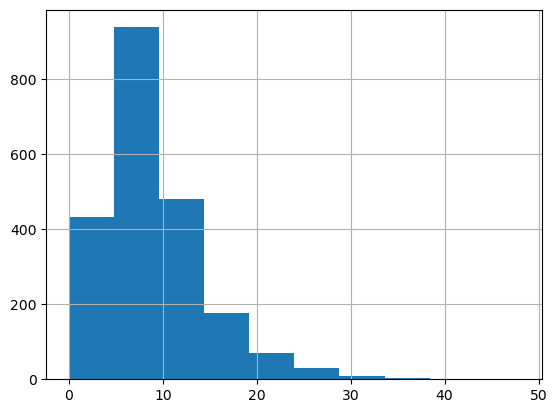

count    2138.000000
mean        8.902713
std         5.399257
min         0.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        48.000000
dtype: float64

In [7]:
reviews_len = [len(x) for x in encoded_reviews]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [10]:
squence_len = 30
features = pad_features(encoded_reviews, squence_len)
print(features)

[[  0   0   0 ...  11  16  62]
 [  0   0   0 ... 128 108  51]
 [  0   0   0 ...  13  62  14]
 ...
 [  0   0   0 ...  24   2  17]
 [  0   0   0 ...   4  40   5]
 [  0   0   0 ...   2  46  35]]


# Split data into training data and testing data

In [11]:
# split data into training data and testing data
texts_train, texts_test, labels_train, labels_test = train_test_split(features, labels, stratify=labels)
print(f"Text_train: {texts_train[:5]}\n\n labels_train: {labels_train[:5]}\n\n\n texts_test: {texts_test[:5]}\n\n labels_test: {labels_test[:5]} ")

Text_train: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   8  33   1   1]
 [  0   0   0   0   0   0   0   0   0   0  37  15   1  32  18 115  88  16
   19  35 137   5 114  77  17  44   1   1  15  41]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13  42
    3  18  18  12  38  27   3  25   2   3  13   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  34   6   6  26   2  20]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 169   1  17]]

 labels_train: [1, 1, 1, 0, 1]


 texts_test: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  50   5
   53 190   3  12   4   7 190   7   2  21  32   9]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0  28  25   4   5  72  12  12  12  16  88  12]
 [  0   0   0   0   0   0   0   0   0   0 183   6   1   4  72  62